# Protein-Ligand Binding Prediction Model with GCN

This notebook implements a Graph Convolutional Network (GCN) to predict protein-ligand binding affinity using preprocessed `.pt` files. The model is optimized for accuracy and fast computation. We include evaluation metrics (MSE, MAE, R²) and visualizations (loss curves, predicted vs. actual scatter plot).

## Step 1: Import Libraries

In [ ]:
# --- Step 1: Import Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem
import optuna
from sklearn.model_selection import KFold



torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Step 2: Load and Preprocess Data

Convert SMILES to graph representations for GCN and use pocket features as additional node features.

In [7]:
class MoleculeDataset(Dataset):
    def __init__(self, smiles_features, pocket_features, labels, smiles_list):
        self.smiles_features = smiles_features
        self.pocket_features = pocket_features
        self.labels = labels
        self.smiles_list = smiles_list
        self.graphs = self._create_graphs()
    
    def _create_graphs(self):
        graphs = []
        for idx, smiles in enumerate(self.smiles_list):
            if idx >= len(self.pocket_features) or idx >= len(self.labels):
                # This check ensures we don't go out of bounds if pocket_features or labels are shorter
                print(f"Skipping SMILES index {idx} due to mismatch in feature/label length.")
                continue
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                try:
                    # Attempt to sanitize and re-parse if initial parsing fails
                    simplified_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles, sanitize=False), isomericSmiles=True)
                    mol = Chem.MolFromSmiles(simplified_smiles)
                    if mol is None:
                        # print(f"Warning: Could not parse SMILES (even after sanitization): {smiles}")
                        continue
                except:
                    # print(f"Warning: Exception during SMILES sanitization: {smiles}")
                    continue
            
            atom_features_list = []
            for atom in mol.GetAtoms():
                features = [
                    atom.GetAtomicNum(),
                    atom.GetDegree(),
                    atom.GetFormalCharge(),
                    atom.GetHybridization().real, # .real to get float from enum
                    atom.GetNumRadicalElectrons(),
                    int(atom.GetIsAromatic()),
                    atom.GetTotalNumHs(),
                    int(atom.IsInRing()),
                    atom.GetMass(), # Consider normalizing or binning if values vary widely
                    atom.GetChiralTag().real, # .real to get float from enum
                    atom.GetImplicitValence(),
                    atom.GetExplicitValence(),
                    atom.GetTotalValence()
                ]
                atom_features_list.append(features)
            
            if not atom_features_list: # Skip if molecule has no atoms after parsing
                # print(f"Warning: Molecule from SMILES {smiles} has no atoms.")
                continue
            x = torch.tensor(atom_features_list, dtype=torch.float)

            edge_index_list = []
            edge_attr_list = []
            for bond in mol.GetBonds():
                i = bond.GetBeginAtomIdx()
                j = bond.GetEndAtomIdx()
                edge_index_list.append([i, j])
                edge_index_list.append([j, i]) # For undirected graphs
                
                bond_features = [
                    bond.GetBondTypeAsDouble(),
                    int(bond.GetIsConjugated()),
                    int(bond.IsInRing()),
                    bond.GetStereo().real, # .real to get float from enum
                ]
                edge_attr_list.append(bond_features)
                edge_attr_list.append(bond_features) # For undirected graphs

            if not edge_index_list: # Handle molecules with no bonds (e.g., single atoms) if necessary
                                   # Or decide to skip them if they are not relevant
                # print(f"Warning: Molecule from SMILES {smiles} has no bonds. Skipping or creating graph with no edges.")
                # Depending on GNN model, graphs with no edges might cause issues or be handled.
                # For now, let's skip if no edges, as GCNs typically rely on them.
                continue
                
            edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
            
            # Retrieve the pre-calculated pocket feature vector for this molecule
            pocket_feature_vector = self.pocket_features[idx] 
            
            # Broadcast pocket features to match the number of atoms and concatenate
            pocket_broadcasted = pocket_feature_vector.repeat(x.shape[0], 1)
            x = torch.cat((x, pocket_broadcasted), dim=1)
            
            graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=self.labels[idx])
            graphs.append(graph)
            
        print(f"Created {len(graphs)} valid graphs out of {len(self.smiles_list)} SMILES strings")
        return graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

# Define amino acid vocabulary
AMINO_ACIDS = sorted(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
                'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']) # Added 'X' for unknown/other
aa_to_int = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
pocket_dim = len(AMINO_ACIDS)

def pocket_sequence_to_feature_vector(sequence, aa_map, vocab_size):
    """Converts a pocket amino acid sequence to a frequency vector."""
    if not isinstance(sequence, str): # Handle potential NaNs or non-string types
        # print(f"Warning: Non-string pocket sequence encountered: {sequence}. Returning zero vector.")
        return torch.zeros(vocab_size, dtype=torch.float)
        
    vector = torch.zeros(vocab_size, dtype=torch.float)
    for aa in sequence.upper(): # Ensure uppercase to match AMINO_ACIDS
        idx = aa_map.get(aa, aa_map.get('X')) # Default to 'X' if amino acid not in map
        if idx is not None:
            vector[idx] += 1
    if len(sequence) > 0:
        vector /= len(sequence) # Normalize to get frequencies
    return vector

# Load CSVs
train_df = pd.read_csv(r"C:\Users\smshr\Downloads\archive (6)\PDBbind\train_dataset.csv")
val_df = pd.read_csv(r"C:\Users\smshr\Downloads\archive (6)\PDBbind\val_dataset.csv")

# Extract SMILES and Labels
train_smiles_list = train_df['smiles'].tolist()
val_smiles_list = val_df['smiles'].tolist()

numeric_cols = train_df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
if not numeric_cols.empty:
    label_col_name = numeric_cols[0] # Assuming the first numeric column is the label
    print(f"Using column '{label_col_name}' for labels.")
    train_labels = torch.tensor(train_df[label_col_name].values, dtype=torch.float)
    val_labels = torch.tensor(val_df[label_col_name].values, dtype=torch.float)
else:
    raise ValueError("No numeric columns found in the DataFrame to use as labels.")


# Process pocket sequences from the dataset
train_pocket_sequences = train_df['pocket'].tolist()
val_pocket_sequences = val_df['pocket'].tolist()

train_pocket_features = torch.stack(
    [pocket_sequence_to_feature_vector(seq, aa_to_int, pocket_dim) for seq in train_pocket_sequences]
)
val_pocket_features = torch.stack(
    [pocket_sequence_to_feature_vector(seq, aa_to_int, pocket_dim) for seq in val_pocket_sequences]
)

print(f"Pocket feature dimension: {pocket_dim}")
print(f"Train pocket features shape: {train_pocket_features.shape}")
print(f"Validation pocket features shape: {val_pocket_features.shape}")


# Dummy smiles_features (not used in graph creation if pocket features are concatenated to atom features)
# If you intend to use smiles_features differently, you'll need to define them properly.
train_smiles_features = torch.ones(len(train_df), 1) # Placeholder
val_smiles_features = torch.ones(len(val_df), 1)   # Placeholder

# Create datasets and loaders
train_dataset = MoleculeDataset(train_smiles_features, train_pocket_features, train_labels, train_smiles_list)
val_dataset = MoleculeDataset(val_smiles_features, val_pocket_features, val_labels, val_smiles_list)

# Ensure batch_size is defined, if not already from Optuna or elsewhere
# batch_size = 32 # Or use the one from best_params if this cell is run after Optuna
if 'best_params' in globals() and 'batch_size' in best_params:
    batch_size = best_params['batch_size']
    print(f"Using batch_size from Optuna: {batch_size}")
else:
    batch_size = 32 # Default if Optuna hasn't run or doesn't define it
    print(f"Using default batch_size: {batch_size}")


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # drop_last can help with BatchNorm issues if last batch is size 1
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

# Example: Check the first graph's node feature dimension
if len(train_dataset) > 0:
    first_graph_train = train_dataset[0]
    print(f"Node feature dimension in the first training graph: {first_graph_train.x.shape[1]}")
else:
    print("Training dataset is empty after processing.")

if len(val_dataset) > 0:
    first_graph_val = val_dataset[0]
    print(f"Node feature dimension in the first validation graph: {first_graph_val.x.shape[1]}")

else:
    print("Validation dataset is empty after processing.")

# --- Prepare data for K-Fold Cross-Validation ---
all_df = pd.concat([train_df, val_df], ignore_index=True)

all_smiles_list = all_df['smiles'].tolist()
# Ensure label_col_name is defined from the initial train_df processing
if 'label_col_name' in locals() and label_col_name in all_df.columns:
    all_labels = torch.tensor(all_df[label_col_name].values, dtype=torch.float)
else:
    # Fallback or error if label_col_name isn't available or not in all_df
    # This assumes the first numeric column is the label, consistent with earlier logic
    numeric_cols_all = all_df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    if not numeric_cols_all.empty:
        label_col_name_all = numeric_cols_all[0]
        print(f"Using column '{label_col_name_all}' for labels in K-Fold from all_df.")
        all_labels = torch.tensor(all_df[label_col_name_all].values, dtype=torch.float)
    else:
        raise ValueError("No numeric columns found in the combined DataFrame to use as labels for K-Fold.")


all_pocket_sequences = all_df['pocket'].tolist()
all_pocket_features = torch.stack(
    [pocket_sequence_to_feature_vector(seq, aa_to_int, pocket_dim) for seq in all_pocket_sequences]
)
# Placeholder for all_smiles_features, consistent with MoleculeDataset structure
all_smiles_features_placeholder = torch.ones(len(all_df), 1)

print(f"Total samples for K-Fold: {len(all_df)}")

Using column 'label' for labels.
Pocket feature dimension: 21
Train pocket features shape: torch.Size([9998, 21])
Validation pocket features shape: torch.Size([1908, 21])


[11:47:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 14 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 25 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 0 P, 6, is greater than permitted
[11:47:41] Explicit valence for atom # 15 P, 6, is greater than permitted
[11:47:41] Explicit valence for atom # 24 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 16 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 24 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 16 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 24 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 16 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 10 C, 5, is greater than permitted
[11:47:41] Explicit valence for atom # 10

Created 5588 valid graphs out of 9998 SMILES strings


[11:47:51] Explicit valence for atom # 0 P, 6, is greater than permitted
[11:47:51] Explicit valence for atom # 15 P, 6, is greater than permitted
[11:47:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:47:51] Explicit valence for atom # 20 C, 5, is greater than permitted
[11:47:51] Explicit valence for atom # 26 N, 4, is greater than permitted
[11:47:51] Explicit valence for atom # 27 N, 4, is greater than permitted
[11:47:51] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:47:51] Explicit valence for atom # 19 C, 5, is greater than permitted
[11:47:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[11:47:51] Explicit valence for atom # 12 C, 5, is greater than permitted
[11:47:51] Explicit valence for atom # 20 C, 4, is greater than permitted
[11:47:51] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:47:51] Explicit valence for atom # 9 P, 7, is greater than permitted
[11:47:51] Explicit valence for atom # 21 P

Created 1038 valid graphs out of 1908 SMILES strings
Using default batch_size: 32
Train samples: 5588
Validation samples: 1038
Node feature dimension in the first training graph: 34
Node feature dimension in the first validation graph: 34
Total samples for K-Fold: 11906


[11:48:00] Explicit valence for atom # 1 C, 5, is greater than permitted


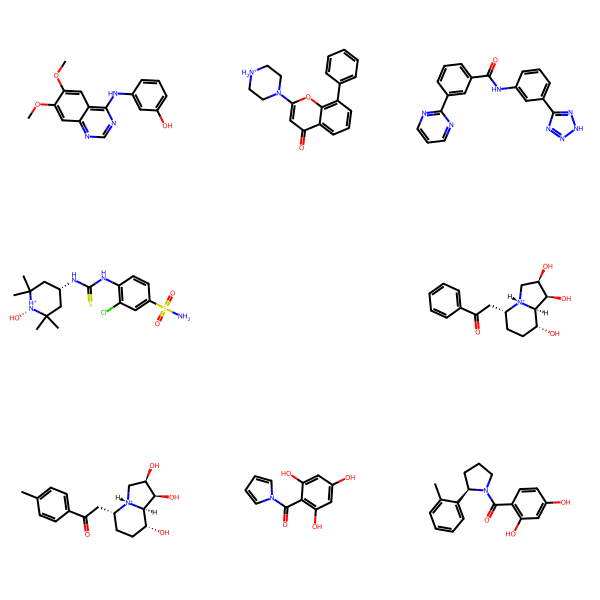

In [8]:
from rdkit.Chem import Draw

# Visualize the first 9 molecules in the validation set
mols = [Chem.MolFromSmiles(s) for s in val_smiles_list[:9]]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200))
img

## Step 3: Define the GAT Model

Use a 3-layer GCN with batch normalization and dropout for better accuracy.

In [9]:
# --- Step 3: Define the GAT Model ---

import torch.nn.functional as F

class GATBindingAffinityModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.4, heads=4):
        super().__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_dim * heads)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.proj = nn.Linear(hidden_dim * heads, hidden_dim)  # Add this line
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1, concat=True)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.to(device)
        edge_index = edge_index.to(device)
        batch = batch.to(device)
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = self.dropout(x2)
        x1_proj = self.proj(x1)  # Project x1 to match x2's shape
        x3 = F.relu(self.bn3(self.conv3(x2 + x1_proj, edge_index)))  # skip connection
        x = global_mean_pool(x3, batch)
        x = self.fc(x)
        return x.squeeze()

In [10]:
# --- Step 4: Hyperparameter Optimization with Optuna ---
import optuna
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, global_mean_pool

def objective(trial):
    input_dim = train_dataset[0].x.shape[1]
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.6)
    heads = trial.suggest_categorical('heads', [2, 4, 8])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model = GATBindingAffinityModel(input_dim, hidden_dim, dropout, heads).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(10):
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch.y)
            loss.backward()
            optimizer.step()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch.y)
            val_loss += loss.item() * batch.num_graphs
    val_loss /= len(val_loader.dataset)
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-05-09 11:48:00,917] A new study created in memory with name: no-name-5bc58fd7-a887-41e0-9290-8eb190f8f854
C:\Users\smshr\AppData\Local\Temp\ipykernel_12476\281215259.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
C:\Users\smshr\AppData\Local\Temp\ipykernel_12476\281215259.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.6)
[I 2025-05-09 11:49:06,848] Trial 0 finished with value: 41.336779566858546 and parameters: {'hidden_dim': 32, 'lr': 1.1519205549916112e-05, 'dropout': 0.3922983388570892, 'heads': 4, 'batch_size': 16}. Best is trial 0 with value: 41.336779566858546.
[I 2

Best hyperparameters: {'hidden_dim': 64, 'lr': 0.0022288255383216896, 'dropout': 0.21024481006223855, 'heads': 2, 'batch_size': 32}


In [11]:
# --- Step 5: Train Final Model with Best Hyperparameters ---

input_dim = train_dataset[0].x.shape[1]

# --- Step 5: Train Final Model with Best Hyperparameters using K-Fold Cross-Validation ---

# Parameters from Optuna (ensure Optuna cell bf125614 has been run)
# If best_params is not defined, set defaults or raise an error
if 'best_params' not in globals():
    print("Warning: best_params not found. Using default hyperparameters for K-Fold.")
    best_params = {'hidden_dim': 64, 'dropout': 0.4, 'heads': 4, 'lr': 0.001, 'batch_size': 32}

hidden_dim = best_params.get('hidden_dim', 64)
dropout_rate = best_params.get('dropout', 0.4) # Renamed to avoid conflict with module
heads = best_params.get('heads', 4)
lr = best_params.get('lr', 0.001)
batch_size = best_params.get('batch_size', 32)

# Assuming input_dim is determined correctly before this cell, e.g., from the first train_dataset
if len(train_dataset) > 0:
    input_dim = train_dataset[0].x.shape[1]
else: # Fallback if train_dataset was empty, try to infer from a sample graph from all_data
    # This part requires careful handling if MoleculeDataset creation for a single item is complex
    # For simplicity, ensure train_dataset (used by Optuna) is populated to get input_dim
    raise ValueError("Cannot determine input_dim, train_dataset is empty.")


num_epochs = 100 # Or best_params.get('num_epochs', 100) if you optimize this
patience = 15
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_metrics = []
all_fold_val_preds = [] # To store predictions from each fold for later ensembling/analysis
all_fold_val_true = []  # To store true values from each fold

# Ensure all_labels, all_smiles_list, all_pocket_features, all_smiles_features_placeholder are available from cell 39af1a5d
indices = np.arange(len(all_df)) # Use indices for splitting

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    # Create datasets and loaders for the current fold
    fold_train_smiles = [all_smiles_list[i] for i in train_idx]
    fold_train_labels_tensor = all_labels[train_idx]
    fold_train_pocket_feats = all_pocket_features[train_idx]
    fold_train_smiles_feats = all_smiles_features_placeholder[train_idx]

    fold_val_smiles = [all_smiles_list[i] for i in val_idx]
    fold_val_labels_tensor = all_labels[val_idx]
    fold_val_pocket_feats = all_pocket_features[val_idx]
    fold_val_smiles_feats = all_smiles_features_placeholder[val_idx]

    fold_train_dataset = MoleculeDataset(fold_train_smiles_feats, fold_train_pocket_feats, fold_train_labels_tensor, fold_train_smiles)
    fold_val_dataset = MoleculeDataset(fold_val_smiles_feats, fold_val_pocket_feats, fold_val_labels_tensor, fold_val_smiles)

    if not fold_train_dataset or not fold_val_dataset:
        print(f"Skipping fold {fold+1} due to empty dataset.")
        continue
        
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    print(f"Fold {fold+1} - Train samples: {len(fold_train_dataset)}, Validation samples: {len(fold_val_dataset)}")
    if len(fold_train_dataset) > 0 and input_dim != fold_train_dataset[0].x.shape[1]:
        print(f"Warning: input_dim mismatch in fold {fold+1}. Optuna input_dim: {input_dim}, Fold input_dim: {fold_train_dataset[0].x.shape[1]}")
        # Adjust input_dim or ensure consistency. For now, we use the Optuna-derived input_dim.

    model = GATBindingAffinityModel(input_dim, hidden_dim, dropout_rate, heads).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_fold_val_loss = float('inf')
    epochs_no_improve = 0
    
    fold_train_losses = []
    fold_val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in fold_train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch.y)
            l2_lambda = 1e-4
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(fold_train_loader.dataset)
        fold_train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        current_fold_preds = []
        current_fold_true = []
        with torch.no_grad():
            for batch in fold_val_loader:
                batch = batch.to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch.y)
                val_loss += loss.item() * batch.num_graphs
                current_fold_preds.extend(outputs.cpu().numpy())
                current_fold_true.extend(batch.y.cpu().numpy())
        val_loss /= len(fold_val_loader.dataset)
        fold_val_losses.append(val_loss)
        
        # print(f'Fold {fold+1}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        scheduler.step(val_loss)

        if val_loss < best_fold_val_loss:
            best_fold_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pt')
            epochs_no_improve = 0
            # print(f"Saved new best model for fold {fold+1} at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} for fold {fold+1}")
                break
    
    print(f"Fold {fold+1} - Best Validation Loss: {best_fold_val_loss:.4f}")
    
    # Load best model for this fold and evaluate
    model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pt'))
    model.eval()
    fold_val_preds_final = []
    fold_val_true_final = []
    with torch.no_grad():
        for batch in fold_val_loader:
            batch = batch.to(device)
            outputs = model(batch)
            fold_val_preds_final.extend(outputs.cpu().numpy())
            fold_val_true_final.extend(batch.y.cpu().numpy())
            
    fold_val_preds_final = np.array(fold_val_preds_final)
    fold_val_true_final = np.array(fold_val_true_final)
    
    all_fold_val_preds.extend(fold_val_preds_final) # These are out-of-sample predictions
    all_fold_val_true.extend(fold_val_true_final)

    mse = mean_squared_error(fold_val_true_final, fold_val_preds_final)
    mae = mean_absolute_error(fold_val_true_final, fold_val_preds_final)
    r2 = r2_score(fold_val_true_final, fold_val_preds_final)
    fold_metrics.append({'mse': mse, 'mae': mae, 'r2': r2, 'loss': best_fold_val_loss})
    print(f"Fold {fold+1} - Validation MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # Store train_losses and val_losses for plotting if needed (e.g., average them)
    # For simplicity, the global train_losses, val_losses are not updated here,
    # but you could plot per-fold or average losses.

# --- Aggregate K-Fold Results ---
avg_mse = np.mean([fm['mse'] for fm in fold_metrics])
avg_mae = np.mean([fm['mae'] for fm in fold_metrics])
avg_r2 = np.mean([fm['r2'] for fm in fold_metrics])
avg_loss = np.mean([fm['loss'] for fm in fold_metrics])

print("\n--- K-Fold Cross-Validation Summary ---")
print(f"Average Validation MSE: {avg_mse:.4f}")
print(f"Average Validation MAE: {avg_mae:.4f}")
print(f"Average Validation R²: {avg_r2:.4f}")
print(f"Average Best Validation Loss: {avg_loss:.4f}")

# The global train_losses and val_losses from the original single train/val split (if any previous cell ran it)
# are not representative of the K-Fold process. You might want to plot averaged losses from K-Fold.
# For now, we remove the direct update to global train_losses, val_losses.
# The variables `train_losses` and `val_losses` in this cell will now refer to the last fold's losses.
# If you need overall average loss curves, you'd collect losses from each fold and average them.
global_train_losses = fold_train_losses # Represents last fold's train losses
global_val_losses = fold_val_losses # Represents last fold's val losses

# `all_fold_val_preds` and `all_fold_val_true` now contain all out-of-sample predictions
# and their true values from the K-Fold process. You can use these for a combined evaluation.
final_oos_mse = mean_squared_error(all_fold_val_true, all_fold_val_preds)
final_oos_mae = mean_absolute_error(all_fold_val_true, all_fold_val_preds)
final_oos_r2 = r2_score(all_fold_val_true, all_fold_val_preds)

print("\n--- Overall Out-of-Sample K-Fold Performance ---")
print(f"Overall OOS MSE: {final_oos_mse:.4f}")
print(f"Overall OOS MAE: {final_oos_mae:.4f}")
print(f"Overall OOS R²: {final_oos_r2:.4f}")

# For plotting, you can use `all_fold_val_true` and `all_fold_val_preds`
# The original `val_true` and `ensemble_mean_preds` will need to be re-evaluated
# if you want to compare against the K-Fold ensemble.
val_true_for_plots = np.array(all_fold_val_true)
predictions_for_plots = np.array(all_fold_val_preds)

[12:12:29] Explicit valence for atom # 25 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 0 P, 6, is greater than permitted
[12:12:29] Explicit valence for atom # 15 P, 6, is greater than permitted
[12:12:29] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 23 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 11 P, 7, is greater than permitted
[12:12:29] Explicit valence for atom # 26 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 1


--- Fold 1/5 ---


[12:12:29] Explicit valence for atom # 0 P, 6, is greater than permitted
[12:12:29] Explicit valence for atom # 11 P, 6, is greater than permitted
[12:12:29] Explicit valence for atom # 2 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:12:29] Explicit valence for atom # 18 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 11 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 50 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:12:29] Explicit valence for atom # 6 P, 7, is greater than permitted
[12:12:29] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 11 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 7 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 54 C, 5, is greater than permitted
[12:12:29] Explicit valence for atom # 23 C,

Created 5343 valid graphs out of 9524 SMILES strings


[12:12:37] Explicit valence for atom # 7 P, 7, is greater than permitted
[12:12:37] Explicit valence for atom # 1 P, 7, is greater than permitted
[12:12:37] Explicit valence for atom # 17 C, 4, is greater than permitted
[12:12:37] Explicit valence for atom # 15 C, 4, is greater than permitted
[12:12:37] Explicit valence for atom # 1 P, 6, is greater than permitted
[12:12:37] Explicit valence for atom # 15 P, 6, is greater than permitted
[12:12:37] Explicit valence for atom # 29 C, 5, is greater than permitted
[12:12:37] Explicit valence for atom # 23 C, 5, is greater than permitted
[12:12:37] Explicit valence for atom # 66 C, 5, is greater than permitted
[12:12:37] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:12:37] Explicit valence for atom # 8 P, 7, is greater than permitted
[12:12:37] Explicit valence for atom # 17 P, 7, is greater than permitted
[12:12:37] Explicit valence for atom # 54 N, 4, is greater than permitted
[12:12:37] Explicit valence for atom # 11 

Created 1283 valid graphs out of 2382 SMILES strings
Fold 1 - Train samples: 5343, Validation samples: 1283
Early stopping at epoch 37 for fold 1
Fold 1 - Best Validation Loss: 2.1691
Fold 1 - Validation MSE: 2.1691, MAE: 1.1526, R2: 0.3772

--- Fold 2/5 ---


[12:14:52] Explicit valence for atom # 2 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 14 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 25 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 0 P, 6, is greater than permitted
[12:14:52] Explicit valence for atom # 15 P, 6, is greater than permitted
[12:14:52] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:14:52] Explicit valence for atom # 10

Created 5314 valid graphs out of 9525 SMILES strings


[12:15:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:15:01] Explicit valence for atom # 21 C, 5, is greater than permitted
[12:15:01] Explicit valence for atom # 26 C, 5, is greater than permitted
[12:15:01] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:15:01] Explicit valence for atom # 48 N, 4, is greater than permitted
[12:15:01] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:15:01] Explicit valence for atom # 26 C, 5, is greater than permitted
[12:15:01] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:15:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:15:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:15:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:15:01] Explicit valence for atom # 26 C, 5, is greater than permitted
[12:15:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:15:01] Explicit valence for atom # 33 C

Created 1312 valid graphs out of 2381 SMILES strings
Fold 2 - Train samples: 5314, Validation samples: 1312
Early stopping at epoch 72 for fold 2
Fold 2 - Best Validation Loss: 1.9294
Fold 2 - Validation MSE: 1.9294, MAE: 1.0950, R2: 0.4276

--- Fold 3/5 ---


[12:19:25] Explicit valence for atom # 2 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 14 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 25 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 0 P, 6, is greater than permitted
[12:19:25] Explicit valence for atom # 15 P, 6, is greater than permitted
[12:19:25] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:19:25] Explicit valence for atom # 10

Created 5278 valid graphs out of 9525 SMILES strings


[12:19:33] Explicit valence for atom # 6 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 8 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 12 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 26 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 0 P, 7, is greater than permitted
[12:19:33] Explicit valence for atom # 15 P, 6, is greater than permitted
[12:19:33] Explicit valence for atom # 9 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:19:33] Explicit valence for atom # 0 P, 7, is greater than permitted
[12:19:33] Explicit valence for atom # 15 P, 6,

Created 1348 valid graphs out of 2381 SMILES strings
Fold 3 - Train samples: 5278, Validation samples: 1348
Early stopping at epoch 62 for fold 3
Fold 3 - Best Validation Loss: 2.0773
Fold 3 - Validation MSE: 2.0773, MAE: 1.1095, R2: 0.3913

--- Fold 4/5 ---


[12:23:47] Explicit valence for atom # 2 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 14 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 25 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 23 C, 5, is greater than permitted
[12:23:47] Explicit valence for atom # 1

Created 5278 valid graphs out of 9525 SMILES strings


[12:24:01] Explicit valence for atom # 13 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 17 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 12 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 19 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 27 P, 7, is greater than permitted
[12:24:01] Explicit valence for atom # 23 P, 7, is greater than permitted
[12:24:01] Explicit valence for atom # 0 P, 7, is greater than permitted
[12:24:01] Explicit valence for atom # 15 P, 7, is greater than permitted
[12:24:01] Explicit valence for atom # 30 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 21 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:24:01] Explicit valence for atom # 14

Created 1348 valid graphs out of 2381 SMILES strings
Fold 4 - Train samples: 5278, Validation samples: 1348
Early stopping at epoch 74 for fold 4
Fold 4 - Best Validation Loss: 2.1219
Fold 4 - Validation MSE: 2.1219, MAE: 1.1306, R2: 0.4336

--- Fold 5/5 ---


[12:29:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 14 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 0 P, 6, is greater than permitted
[12:29:24] Explicit valence for atom # 15 P, 6, is greater than permitted
[12:29:24] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 24 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 16 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:29:24] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:29:24] Explicit valence for atom # 42 C, 5, is greater than permitted
[12:29:24] Explicit valence for atom # 1

Created 5291 valid graphs out of 9525 SMILES strings


[12:29:33] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:29:33] Explicit valence for atom # 15 C, 5, is greater than permitted
[12:29:33] Explicit valence for atom # 21 P, 7, is greater than permitted
[12:29:33] Explicit valence for atom # 48 C, 5, is greater than permitted
[12:29:33] Explicit valence for atom # 16 P, 7, is greater than permitted
[12:29:33] Explicit valence for atom # 10 P, 7, is greater than permitted
[12:29:33] Explicit valence for atom # 18 P, 7, is greater than permitted
[12:29:33] Explicit valence for atom # 11 P, 7, is greater than permitted
[12:29:33] Explicit valence for atom # 16 P, 7, is greater than permitted
[12:29:33] Explicit valence for atom # 13 P, 7, is greater than permitted
[12:29:33] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:29:33] Explicit valence for atom # 18 C, 5, is greater than permitted
[12:29:33] Explicit valence for atom # 22 C, 5, is greater than permitted
[12:29:33] Explicit valence for atom # 5

Created 1335 valid graphs out of 2381 SMILES strings
Fold 5 - Train samples: 5291, Validation samples: 1335
Early stopping at epoch 58 for fold 5
Fold 5 - Best Validation Loss: 1.9003
Fold 5 - Validation MSE: 1.9003, MAE: 1.0689, R2: 0.4430

--- K-Fold Cross-Validation Summary ---
Average Validation MSE: 2.0396
Average Validation MAE: 1.1113
Average Validation R²: 0.4145
Average Best Validation Loss: 2.0396

--- Overall Out-of-Sample K-Fold Performance ---
Overall OOS MSE: 2.0392
Overall OOS MAE: 1.1111
Overall OOS R²: 0.4152


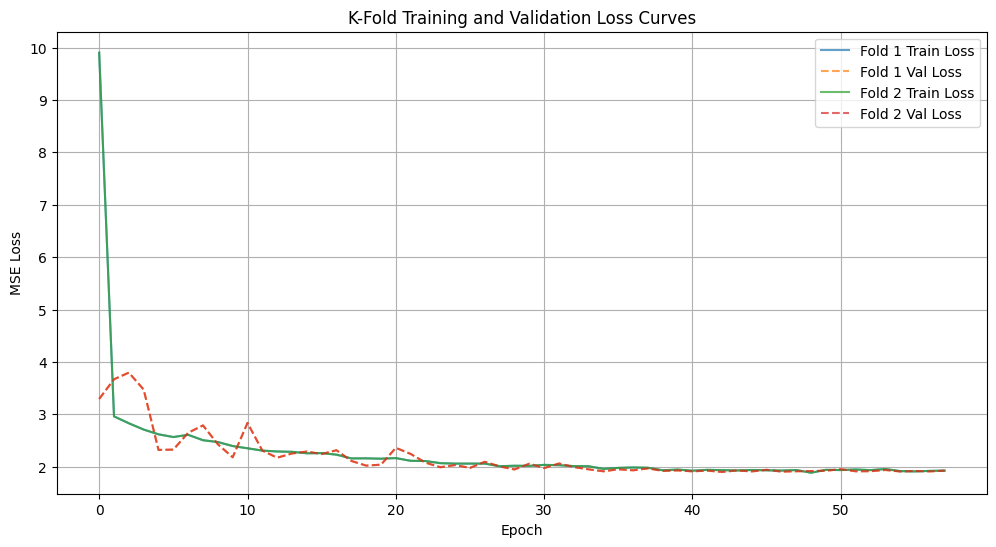

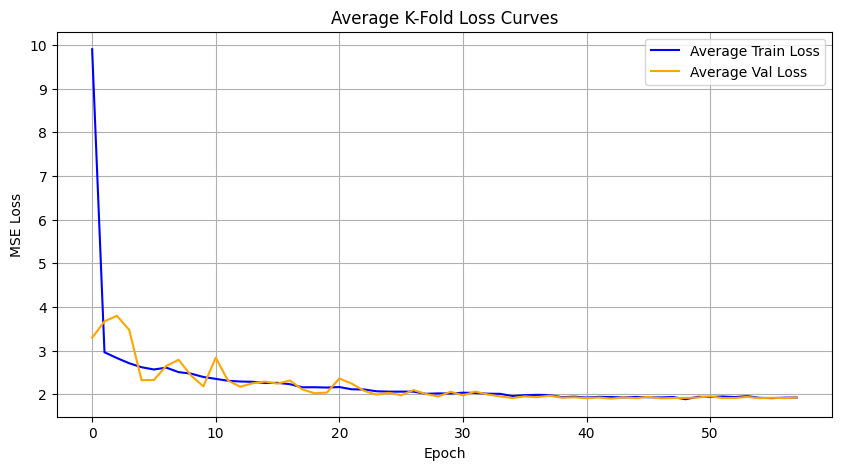

In [21]:
# ...existing code...

# Collect all folds' losses for plotting
if 'all_folds_train_losses' not in globals():
    all_folds_train_losses = []
if 'all_folds_val_losses' not in globals():
    all_folds_val_losses = []

all_folds_train_losses.append(fold_train_losses)
all_folds_val_losses.append(fold_val_losses)

# After K-Fold loop, plot all folds' loss curves
plt.figure(figsize=(12, 6))
for i, (train_l, val_l) in enumerate(zip(all_folds_train_losses, all_folds_val_losses)):
    plt.plot(train_l, label=f'Fold {i+1} Train Loss', alpha=0.7)
    plt.plot(val_l, label=f'Fold {i+1} Val Loss', linestyle='--', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('K-Fold Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot average loss curve across folds
min_len = min(len(l) for l in all_folds_train_losses)
avg_train = np.mean([l[:min_len] for l in all_folds_train_losses], axis=0)
avg_val = np.mean([l[:min_len] for l in all_folds_val_losses], axis=0)
plt.figure(figsize=(10, 5))
plt.plot(avg_train, label='Average Train Loss', color='blue')
plt.plot(avg_val, label='Average Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Average K-Fold Loss Curves')
plt.legend()
plt.grid(True)
plt.show()
# ...existing code...

In [22]:
# --- Step 6: K-Fold Ensemble Evaluation on Original Validation Set ---
# This cell now uses the models trained during K-Fold.

# Ensure original val_dataset and val_loader are available if you want to evaluate on them
# These were defined in cell 39af1a5d before K-Fold modifications
# Recreate val_loader for the original validation set if not available globally
# For simplicity, let's assume `val_dataset` (the original one) is still accessible.
# If not, you'd reload it or pass it appropriately.

# Make sure `val_dataset` (the original one, not from a fold) is defined
if 'val_dataset' not in globals() or not val_dataset:
    print("Original val_dataset not found for K-Fold ensemble evaluation. Skipping.")
else:
    original_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Use best_params batch_size

    ensemble_preds_on_val = []
    n_splits = 5 # Should match KFold n_splits

    # Determine input_dim (should be consistent)
    if len(val_dataset) > 0:
        # It's safer to get input_dim from the data the model will see
        # However, the models were trained with `input_dim` from the K-Fold setup.
        # We assume `input_dim` (from Optuna/K-Fold training) is correct.
        pass # input_dim is already defined
    else:
        raise ValueError("Original val_dataset is empty, cannot proceed with ensemble evaluation.")

    for i in range(n_splits):
        fold_model_path = f'best_model_fold_{i+1}.pt'
        # Parameters used for model instantiation should match those during K-Fold training
        model_ens = GATBindingAffinityModel(input_dim, hidden_dim, dropout_rate, heads).to(device)
        try:
            model_ens.load_state_dict(torch.load(fold_model_path))
        except FileNotFoundError:
            print(f"Warning: Model file {fold_model_path} not found. Skipping this fold for ensemble.")
            continue
        except Exception as e:
            print(f"Warning: Could not load model {fold_model_path}. Error: {e}. Skipping.")
            continue
            
        model_ens.eval()
        preds = []
        with torch.no_grad():
            for batch in original_val_loader: # Evaluate on the original validation set
                batch = batch.to(device)
                outputs = model_ens(batch)
                preds.extend(outputs.cpu().numpy())
        if preds: # Only append if predictions were made
             ensemble_preds_on_val.append(np.array(preds))

    if ensemble_preds_on_val:
        # Ensure all prediction arrays have the same length before stacking
        min_len = min(len(p) for p in ensemble_preds_on_val)
        ensemble_preds_on_val = [p[:min_len] for p in ensemble_preds_on_val]
        
        stacked_preds = np.stack(ensemble_preds_on_val, axis=0)
        ensemble_mean_preds_on_val = np.mean(stacked_preds, axis=0)

        # Get true labels from the original val_dataset
        original_val_true = []
        for data_item in val_dataset: # Iterate through original val_dataset
            y_val = data_item.y
            if hasattr(y_val, "item"):
                y_val = y_val.item()
            original_val_true.append(float(y_val))
        original_val_true = np.array(original_val_true)
        
        # Adjust length if min_len was used due to inconsistencies
        original_val_true = original_val_true[:ensemble_mean_preds_on_val.shape[0]]


        mse_ens = mean_squared_error(original_val_true, ensemble_mean_preds_on_val)
        mae_ens = mean_absolute_error(original_val_true, ensemble_mean_preds_on_val)
        r2_ens = r2_score(original_val_true, ensemble_mean_preds_on_val)

        print(f'\n--- K-Fold Ensemble (on original val_dataset) ---')
        print(f'Ensemble Validation MSE: {mse_ens:.4f}')
        print(f'Ensemble Validation MAE: {mae_ens:.4f}')
        print(f'Ensemble Validation R²: {r2_ens:.4f}')
        
        # For plotting, you can now use original_val_true and ensemble_mean_preds_on_val
        # Update the variables used by your plotting cells if you want to visualize this ensemble
        val_true_for_plots = original_val_true
        predictions_for_plots = ensemble_mean_preds_on_val
    else:
        print("No models were successfully loaded for K-Fold ensemble evaluation.")

# Update plotting cells (e.g., cell 939375df) to use `val_true_for_plots` and `predictions_for_plots`
# For example, in cell 939375df:
# plt.scatter(val_true_for_plots, predictions_for_plots, alpha=0.5)
# plt.plot([val_true_for_plots.min(), val_true_for_plots.max()], [val_true_for_plots.min(), val_true_for_plots.max()], 'r--', lw=2)
# And similarly for residual plots.


--- K-Fold Ensemble (on original val_dataset) ---
Ensemble Validation MSE: 1.7152
Ensemble Validation MAE: 1.0358
Ensemble Validation R²: 0.5853


## Step 5: Evaluate the Model

Compute MSE, MAE, and R² on the validation set.

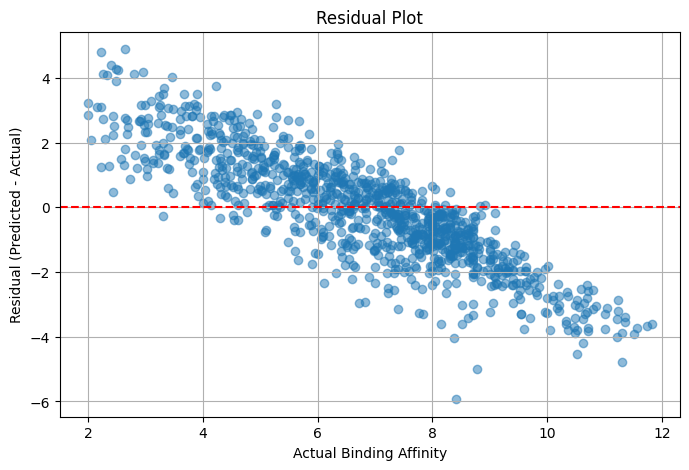

In [ ]:
# Residual plot
residuals = ensemble_mean_preds - val_true
plt.figure(figsize=(8, 5))
plt.scatter(val_true, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Binding Affinity')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

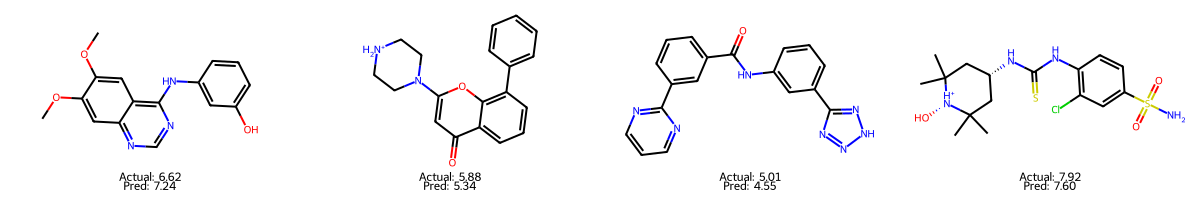

In [30]:
from rdkit.Chem import Draw

# Number of molecules to show
n_show = 4  # Change as needed

# Prepare legends with actual and predicted values
legends = [f"Actual: {a:.2f}\nPred: {p:.2f}" for a, p in zip(val_true_for_plots[:n_show], predictions_for_plots[:n_show])]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(s) for s in val_smiles_list[:n_show]]

# Draw molecules in a grid with legends
img = Draw.MolsToGridImage(mols, molsPerRow=n_show, subImgSize=(300,200), legends=legends)
img

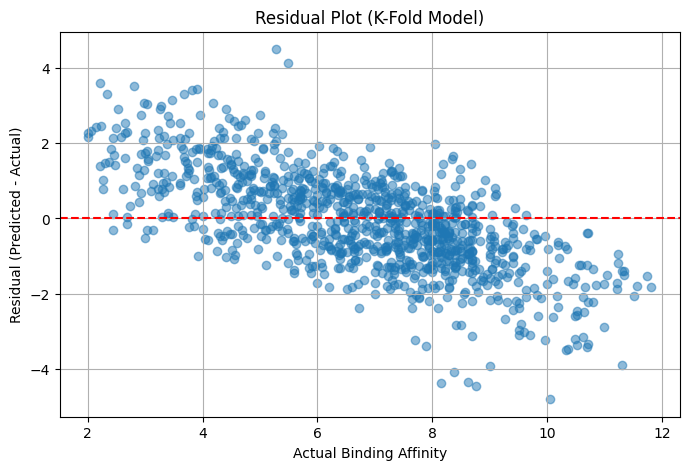

In [24]:
# Residual plot for K-Fold model
residuals_kfold = predictions_for_plots - val_true_for_plots
plt.figure(figsize=(8, 5))
plt.scatter(val_true_for_plots, residuals_kfold, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Binding Affinity')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot (K-Fold Model)')
plt.grid(True)
plt.show()

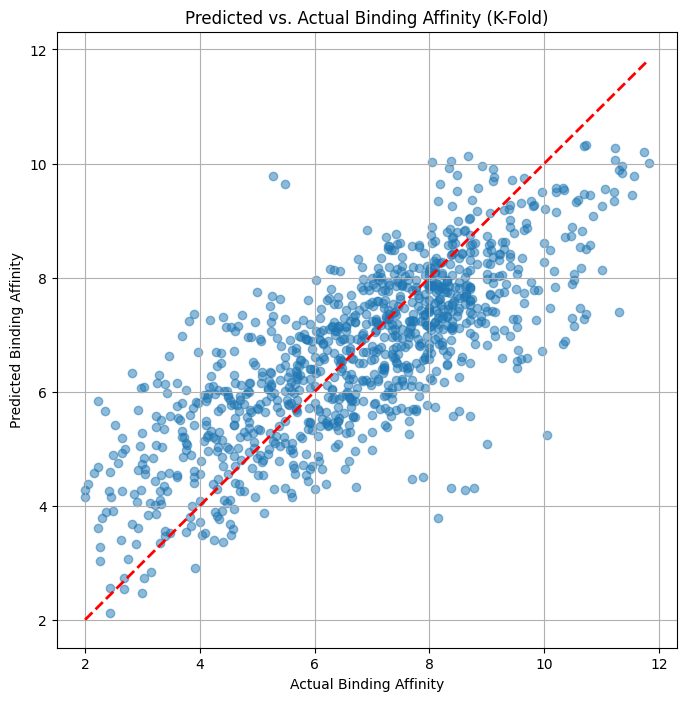

In [25]:
plt.figure(figsize=(8, 8))
plt.scatter(val_true_for_plots, predictions_for_plots, alpha=0.5)
plt.plot([val_true_for_plots.min(), val_true_for_plots.max()],
         [val_true_for_plots.min(), val_true_for_plots.max()], 'r--', lw=2)
plt.xlabel('Actual Binding Affinity')
plt.ylabel('Predicted Binding Affinity')
plt.title('Predicted vs. Actual Binding Affinity (K-Fold)')
plt.grid(True)
plt.show()

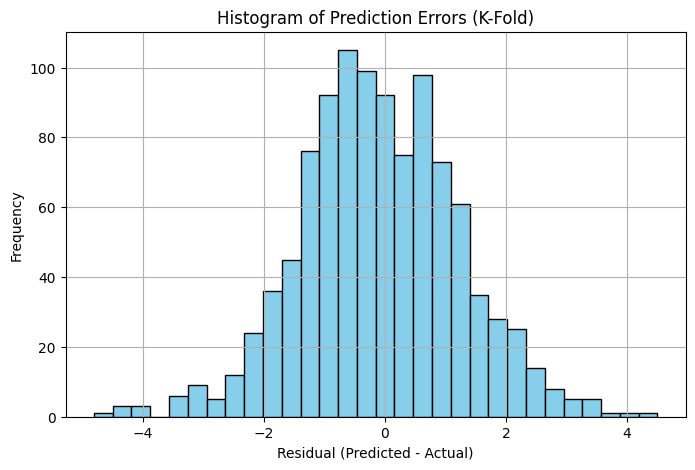

In [27]:
plt.figure(figsize=(8, 5))
plt.hist(residuals_kfold, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Residual (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors (K-Fold)')
plt.grid(True)
plt.show()

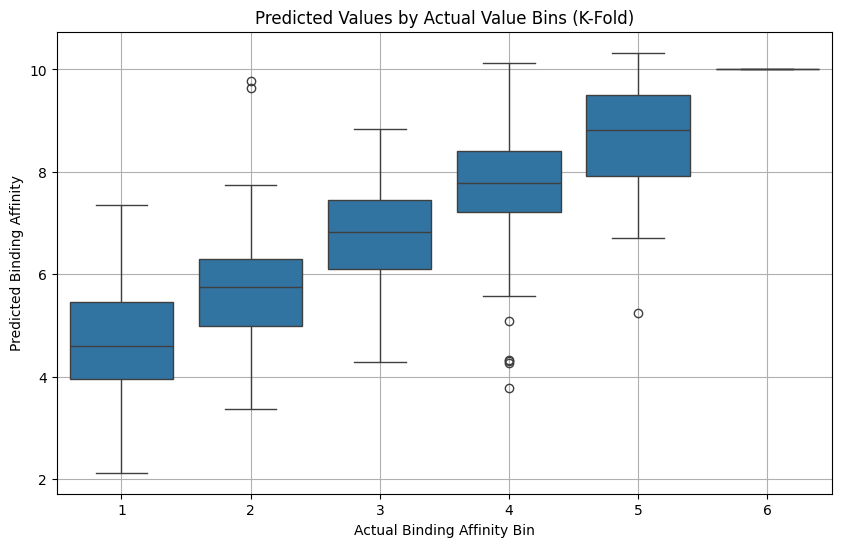

In [28]:
import seaborn as sns
bins = np.linspace(val_true_for_plots.min(), val_true_for_plots.max(), 6)
digitized = np.digitize(val_true_for_plots, bins)
plt.figure(figsize=(10, 6))
sns.boxplot(x=digitized, y=predictions_for_plots)
plt.xlabel('Actual Binding Affinity Bin')
plt.ylabel('Predicted Binding Affinity')
plt.title('Predicted Values by Actual Value Bins (K-Fold)')
plt.grid(True)
plt.show()